<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw4/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW4

References

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/

https://towardsdatascience.com/credit-card-customer-clustering-with-autoencoder-and-k-means-16654d54e64e

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
(X_train_ori, y_train), (X_test_ori, y_test) = keras.datasets.mnist.load_data()
assert X_train_ori.shape == (60000, 28, 28)
assert X_test_ori.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [3]:
def select_data(n, X_train, y_train):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    indices_all_classes = []

    for each_class in classes:
        indices = [i for i, x in enumerate(y_train) if x == each_class]
        indices_all_classes.append(indices)

    new_X_train = []
    new_y_train = []

    for class_indices in indices_all_classes:
        x, y = X_train[class_indices[:n]], y_train[class_indices[:n]]
        new_X_train.extend(x)
        new_y_train.extend(y)

    return np.array(new_X_train), np.array(new_y_train)

In [4]:
def prepare_data(X_train, y_train):
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_train = np.repeat(X_train, 3, axis=-1)
    X_train = X_train.astype('float32') / 255
    # X_train = tf.image.resize(X_train, [224, 224])
    # y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    return X_train, y_train

In [5]:
def shuffle_data(X_train, y_train, N):
    indices = tf.range(start=0, limit=N, dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)

    shuffled_x = tf.gather(X_train, shuffled_indices)
    shuffled_y = tf.gather(y_train, shuffled_indices)
    return shuffled_x.numpy(), shuffled_y.numpy()

# QN 1

Pick 100 samples from each of the 10 classes. Take all these 1,000 images and run them through a k-means clustering algorithm (k=10).

In [6]:
# Nx10 data - 10 from each category

N=100
X_train_100, y_train_100 = select_data(N, X_train_ori, y_train)
X_train_100, y_train_100 = prepare_data(X_train_100, y_train_100)
X_train_100, y_train_100 = shuffle_data(X_train_100, y_train_100, N)

X_train_100 = X_train_100.reshape(len(X_train_100), -1)
X_train_100.shape

(100, 784)

## Kmeans

In [7]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0).fit(X_train_100)
predicted_labels = kmeans.labels_

## Accuracy

In [8]:
cm = confusion_matrix(y_train_100, predicted_labels)

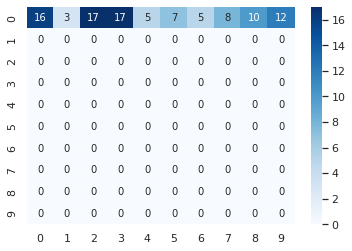

In [9]:
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [10]:
np.trace(cm) / np.sum(cm)

0.16

*Kmeans gives you cluster numbers that are different from the class labels. You have to convert those clusters numbers to their corresponding class labels, i.e if for example, if more than  50% of images in cluster 1 are from class 5, that cluster should be reassigned number 5.* - from TA

In [11]:
def linear_assignment(cost_matrix):
  try:
    import lap
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    return np.array([[y[i], i] for i in x if i >= 0])
  except ImportError:
    from scipy.optimize import linear_sum_assignment
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

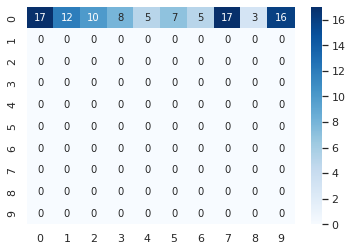

In [12]:
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [13]:
np.trace(cm2) / np.sum(cm2)

0.17

# QN 2

This time we will take 1,000 images from each of the 10 MNIST classes giving us 10,000 images. Build an autoencoder and train it.

In [14]:
# Nx10 data - 10 from each category

N=1000
X_train_1000, y_train_1000 = select_data(N, X_train_ori, y_train)
X_train_1000, y_train_1000 = prepare_data(X_train_1000, y_train_1000)
X_train_1000, y_train_1000 = shuffle_data(X_train_1000, y_train_1000, N)

X_test_1000, y_test_1000 = select_data(N, X_test_ori, y_test)
X_test_1000, y_test_1000 = prepare_data(X_test_1000, y_test_1000)
X_test_1000, y_test_1000 = shuffle_data(X_test_1000, y_test_1000, N)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [16]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEncoder()

In [18]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [19]:
autoencoder.fit(X_train_1000, X_train_1000,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_ori, X_test_ori))

Epoch 1/10
32/32 [==============================] - 8s 28ms/step - loss: 0.2095 - val_loss: 7410.1743
Epoch 2/10
32/32 [==============================] - 1s 21ms/step - loss: 0.1303 - val_loss: 7409.9697
Epoch 3/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0744 - val_loss: 7374.0786
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0359 - val_loss: 7344.4639
Epoch 5/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0153 - val_loss: 7344.4414
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0100 - val_loss: 7344.7666
Epoch 7/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0088 - val_loss: 7345.0186
Epoch 8/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0080 - val_loss: 7344.7920
Epoch 9/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0074 - val_loss: 7344.6602
Epoch 10/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0069 -

In [20]:
encoded_imgs = autoencoder.encoder(X_test_ori).numpy()
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs), -1)

In [21]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0).fit(encoded_imgs)
predicted_labels = kmeans.labels_
cm = confusion_matrix(y_test, predicted_labels)

In [22]:
indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

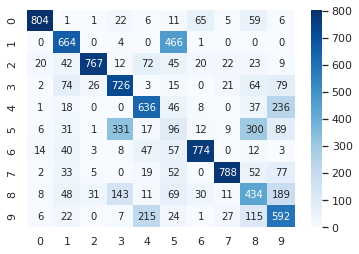

In [23]:
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [24]:
np.trace(cm2) / np.sum(cm2)

0.6281

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(encoded_imgs)

In [26]:
reduced_data.shape

(10000, 2)

#QN 3

Start with an untrained autoencoder. Train it by adding noise input images and using the original images to compare against.

In [32]:
def de_noising(amount_of_denoise):
    noise_factor = amount_of_denoise
    x_train_noisy = X_train_1000 + noise_factor * tf.random.normal(shape=X_train_1000.shape)
    x_test_noisy = X_test_ori + noise_factor * tf.random.normal(shape=X_test_ori.shape)

    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

    autoencoder.fit(x_train_noisy, X_train_1000,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, X_test_ori))
    
    encoded_imgs = autoencoder.encoder(X_test_ori).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(X_test_ori[i]))
        plt.gray()
    plt.show()

    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(x_test_noisy[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

Epoch 1/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0051 - val_loss: 7345.5054
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0051 - val_loss: 7345.4990
Epoch 3/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0050 - val_loss: 7345.5088
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0050 - val_loss: 7345.4937
Epoch 5/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0050 - val_loss: 7345.4951
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0049 - val_loss: 7345.0601
Epoch 7/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0049 - val_loss: 7345.4951
Epoch 8/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0049 - val_loss: 7345.3223
Epoch 9/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0048 - val_loss: 7345.0713
Epoch 10/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0048 -

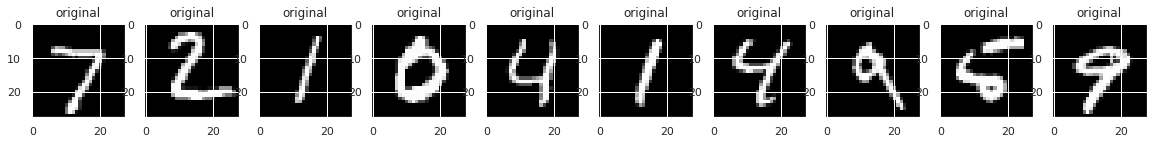

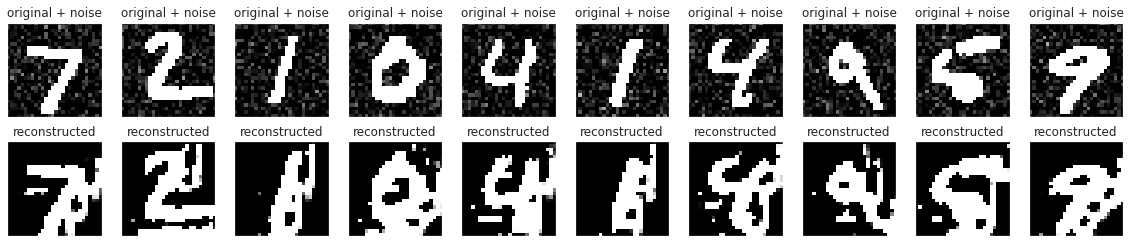

In [33]:
de_noising(0.2)

##Bonus

Experiment with 5 different amounts of noise and show the results.

Epoch 1/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0125 - val_loss: 7345.0718
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0118 - val_loss: 7345.2144
Epoch 3/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0117 - val_loss: 7345.2607
Epoch 4/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0116 - val_loss: 7345.5088
Epoch 5/10
32/32 [==============================] - 1s 32ms/step - loss: 0.0115 - val_loss: 7345.3647
Epoch 6/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0114 - val_loss: 7345.6250
Epoch 7/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0114 - val_loss: 7345.5425
Epoch 8/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0114 - val_loss: 7345.3999
Epoch 9/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0113 - val_loss: 7345.7866
Epoch 10/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0113 -

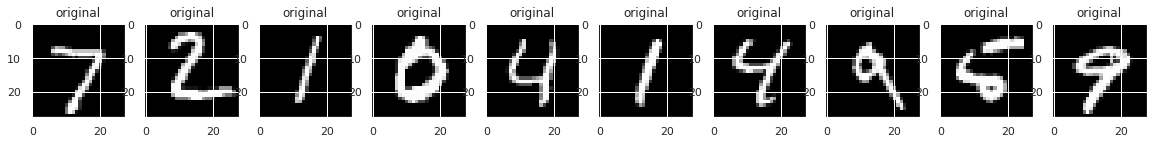

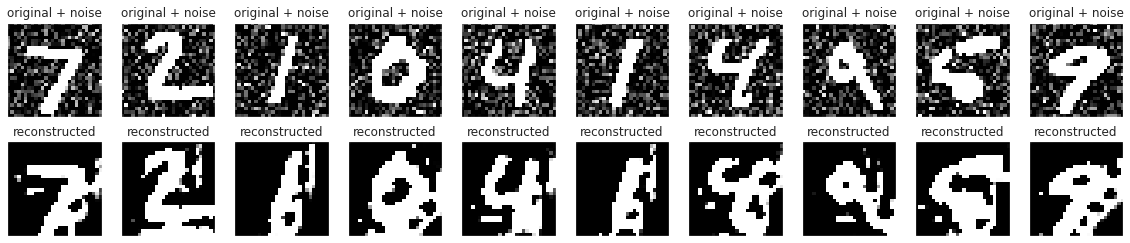

In [34]:
de_noising(0.4)

Epoch 1/10
32/32 [==============================] - 1s 28ms/step - loss: 0.0172 - val_loss: 7348.0742
Epoch 2/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0160 - val_loss: 7346.8633
Epoch 3/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0156 - val_loss: 7346.4351
Epoch 4/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0155 - val_loss: 7346.5127
Epoch 5/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0154 - val_loss: 7346.3105
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0154 - val_loss: 7346.4199
Epoch 7/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0153 - val_loss: 7346.1626
Epoch 8/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0153 - val_loss: 7346.4233
Epoch 9/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0152 - val_loss: 7346.2832
Epoch 10/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0152 -

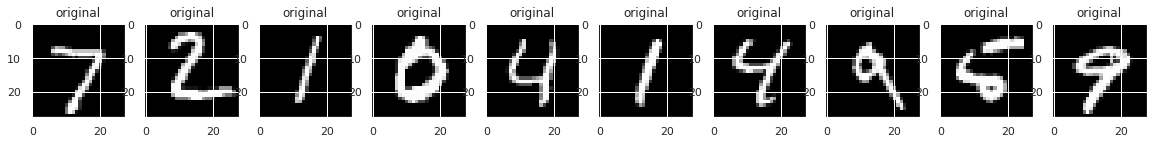

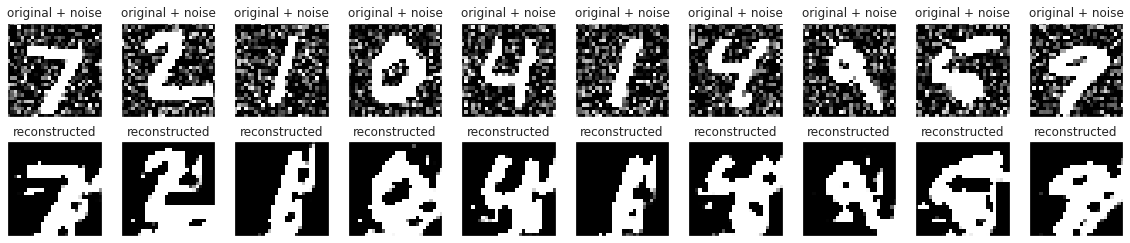

In [38]:
de_noising(0.5)

Epoch 1/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0228 - val_loss: 7345.7754
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0218 - val_loss: 7345.7065
Epoch 3/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0216 - val_loss: 7345.3682
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0218 - val_loss: 7346.1655
Epoch 5/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0214 - val_loss: 7346.0737
Epoch 6/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0214 - val_loss: 7346.4146
Epoch 7/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0212 - val_loss: 7346.1450
Epoch 8/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0212 - val_loss: 7345.8345
Epoch 9/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0212 - val_loss: 7346.0898
Epoch 10/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0211 -

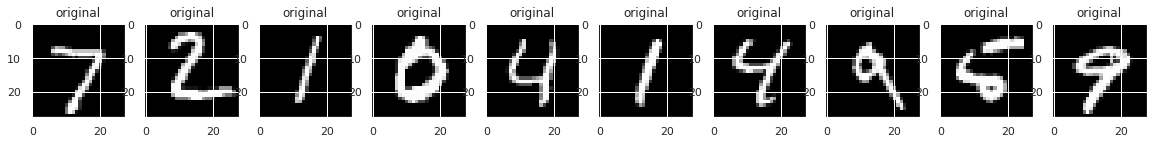

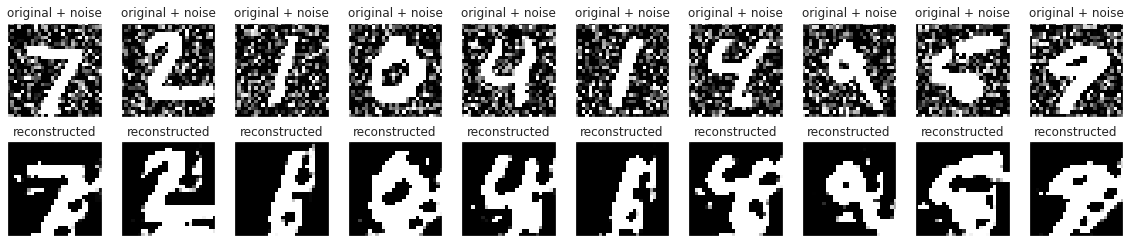

In [35]:
de_noising(0.6)

Epoch 1/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0342 - val_loss: 7346.3750
Epoch 2/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0337 - val_loss: 7347.4814
Epoch 3/10
32/32 [==============================] - 1s 27ms/step - loss: 0.0333 - val_loss: 7346.8306
Epoch 4/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0336 - val_loss: 7346.5615
Epoch 5/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0332 - val_loss: 7347.1895
Epoch 6/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0331 - val_loss: 7347.3257
Epoch 7/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0330 - val_loss: 7347.2168
Epoch 8/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0329 - val_loss: 7347.0674
Epoch 9/10
32/32 [==============================] - 1s 27ms/step - loss: 0.0329 - val_loss: 7347.6177
Epoch 10/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0331 -

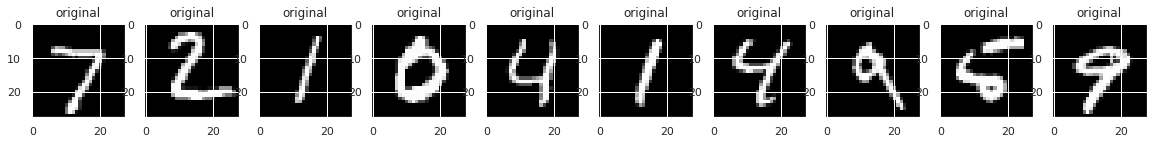

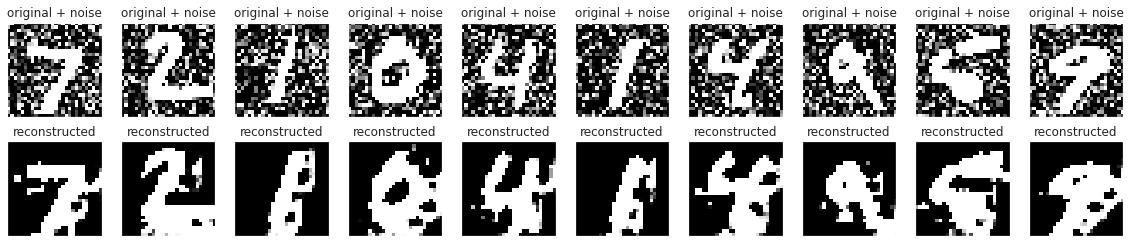

In [36]:
de_noising(0.8)

Epoch 1/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0390 - val_loss: 7347.4990
Epoch 2/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0386 - val_loss: 7347.6602
Epoch 3/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0384 - val_loss: 7348.1016
Epoch 4/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0383 - val_loss: 7348.0410
Epoch 5/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0384 - val_loss: 7348.2671
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0383 - val_loss: 7348.6895
Epoch 7/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0388 - val_loss: 7348.6401
Epoch 8/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0384 - val_loss: 7348.0967
Epoch 9/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0382 - val_loss: 7348.3330
Epoch 10/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0382 -

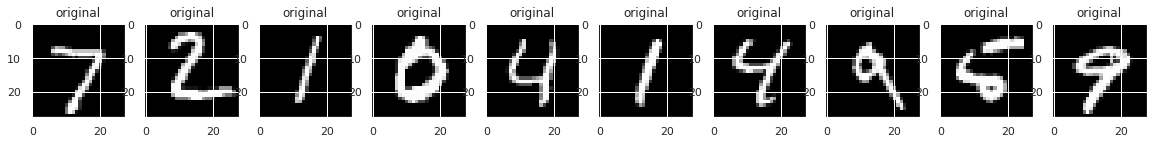

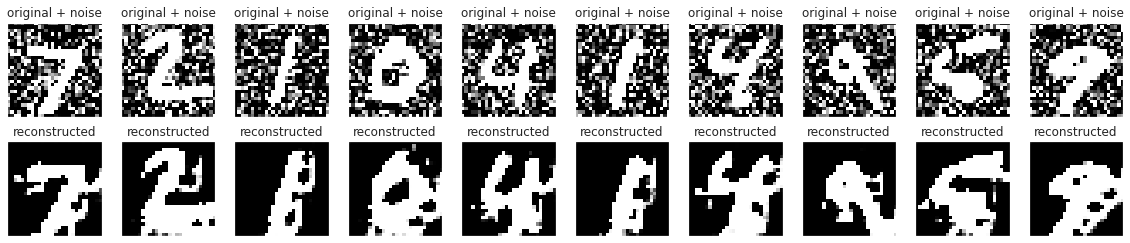

In [37]:
de_noising(0.9)